In [773]:
import json
import requests
import os
import zipfile
import geopandas as gpd 
import pandas as pd
import contextily as cx
import numpy as np
import io
from pandas import json_normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from minisom import MiniSom


## CLUSTERING POR RESTAURANTES

El objetivo principal de este proyecto es lograr dar recomendaciones de posibles ubicaciones para abrir restaurantes de cierto giro.
El primer para conseguir esto es usar K-means para agrupar los AGEBs en clusters, utilizando datos de frecuencia de restaurantes. Estos clusters serviránpara identificar patrones y similitudes entre diferentes áreas en términos de la disponibilidad y variedad de restaurantes.

In [774]:
#leemos el archicvo shape de los agebs de Nuevo León
gdf = gpd.read_file("DF_FINAL.shp").to_crs(4326)

In [775]:
gdf.head()

CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  VPH_REFRI  VPH_TELEF  Restaurant  Restaura_1  \
0   10712     2186  ...       2786       1874           0           2   
1    9224     1185  ...       2538       1712           0           0   
2    4650      638  ...       1404       1128           0           0   
3       0        0  ...          0          0           8           2   
4    8268     1230  ...       2168       1343           0           1   

   Restaura_2  Restaura_3  Restaura_4  Restaura_5  Restaura_6  \
0           0           3           3           1           3   
1           0           1           1           3           0   
2           0           2           1           0           0   
3           1           3           3           6           0   
4           0           1           0           0           0   

                                            geometry  
0  POLYGON ((-100.15091 25.71505, -100.15099 25.7...  
1  POLYGON ((-100.16946 25.75323, -100.16861 25.7...  
2  POLYGON ((-100.23345 25.77729, -100.23349 25.7...  
3  POLYGON ((-100.18562 25.77552, -100.18542 25.7...  
4  POLYGON ((-100.16562 25.73954, -100.16554 25.7...  

[5 rows x 25 columns]

In [776]:
nuevos_nombres = {'Restaurant': 'Rest_Carta',
                  'Restaura_1': 'Rest_Antojitos',
                  'Restaura_2': 'Rest_Mariscos',
                  'Restaura_3': 'Rest_Rapida',
                  'Restaura_4': 'Rest_TacosTortas',
                  'Restaura_5': 'Rest_Autoserv',
                  'Restaura_6': 'Rest_OtrosLlevar',
                  }

gdf.rename(columns=nuevos_nombres, inplace=True)
gdf.head()


CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  VPH_REFRI  VPH_TELEF  Rest_Carta  Rest_Antojitos  \
0   10712     2186  ...       2786       1874           0               2   
1    9224     1185  ...       2538       1712           0               0   
2    4650      638  ...       1404       1128           0               0   
3       0        0  ...          0          0           8               2   
4    8268     1230  ...       2168       1343           0               1   

   Rest_Mariscos  Rest_Rapida  Rest_TacosTortas  Rest_Autoserv  \
0              0            3                 3              1   
1              0            1                 1              3   
2              0            2                 1              0   
3              1            3                 3              6   
4              0            1                 0              0   

   Rest_OtrosLlevar                                           geometry  
0                 3  POLYGON ((-100.15091 25.71505, -100.15099 25.7...  
1                 0  POLYGON ((-100.16946 25.75323, -100.16861 25.7...  
2                 0  POLYGON ((-100.23345 25.77729, -100.23349 25.7...  
3                 0  POLYGON ((-100.18562 25.77552, -100.18542 25.7...  
4                 0  POLYGON ((-100.16562 25.73954, -100.16554 25.7...  

[5 rows x 25 columns]

In [777]:
##Prueba
# columnas relevantes para el clustering
columnas_clustering2= ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       'POBTOT'
                       ]

# creo dataframe solo con las colmnas seleccionadas
datos_clustering2 = gdf[columnas_clustering2]

In [778]:
datos_clustering2

Rest_Carta  Rest_Antojitos  Rest_Mariscos  Rest_Rapida  \
0              0               2              0            3   
1              0               0              0            1   
2              0               0              0            2   
3              8               2              1            3   
4              0               1              0            1   
...          ...             ...            ...          ...   
1282           1               2              0            2   
1283           0               1              0            2   
1284           0               0              0            0   
1285           0               1              0            0   
1286           0               0              0            2   

      Rest_TacosTortas  Rest_Autoserv  Rest_OtrosLlevar  POBTOT  
0                    3              1                 3   10712  
1                    1              3                 0    9224  
2                    1              0                 0    4650  
3                    3              6                 0       0  
4                    0              0                 0    8268  
...                ...            ...               ...     ...  
1282                 3              1                 1    6710  
1283                 2              0                 0    4866  
1284                 1              0                 0       0  
1285                 0              0                 0    5766  
1286                 1              0                 1    8148  

[1287 rows x 8 columns]

In [779]:
# columnas relevantes para el clustering
columnas_clustering = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar'
                       ]

# creo dataframe solo con las colmnas seleccionadas
datos_clustering = gdf[columnas_clustering]


Debido a que las variables de frecuencia de restaurantes pueden tener diferentes escalas y magnitudes, la normalización garantiza que todas las variables contribuyan equitativamente al cálculo de la distancia entre puntos. Es por esto ue se normalizan los datos para entrenar el modelo:

In [780]:
# Normalizamos los datos
scaler = StandardScaler()
datos_normalizados = scaler.fit_transform(datos_clustering)

In [781]:
datos_normalizados2 = scaler.fit_transform(datos_clustering2)

In [782]:
gdf['Cluster'] = cluster_index

# distribución de los clusters
print(gdf['Cluster'].value_counts())

Cluster
1    754
2    339
3    100
4     71
0     23
Name: count, dtype: int64


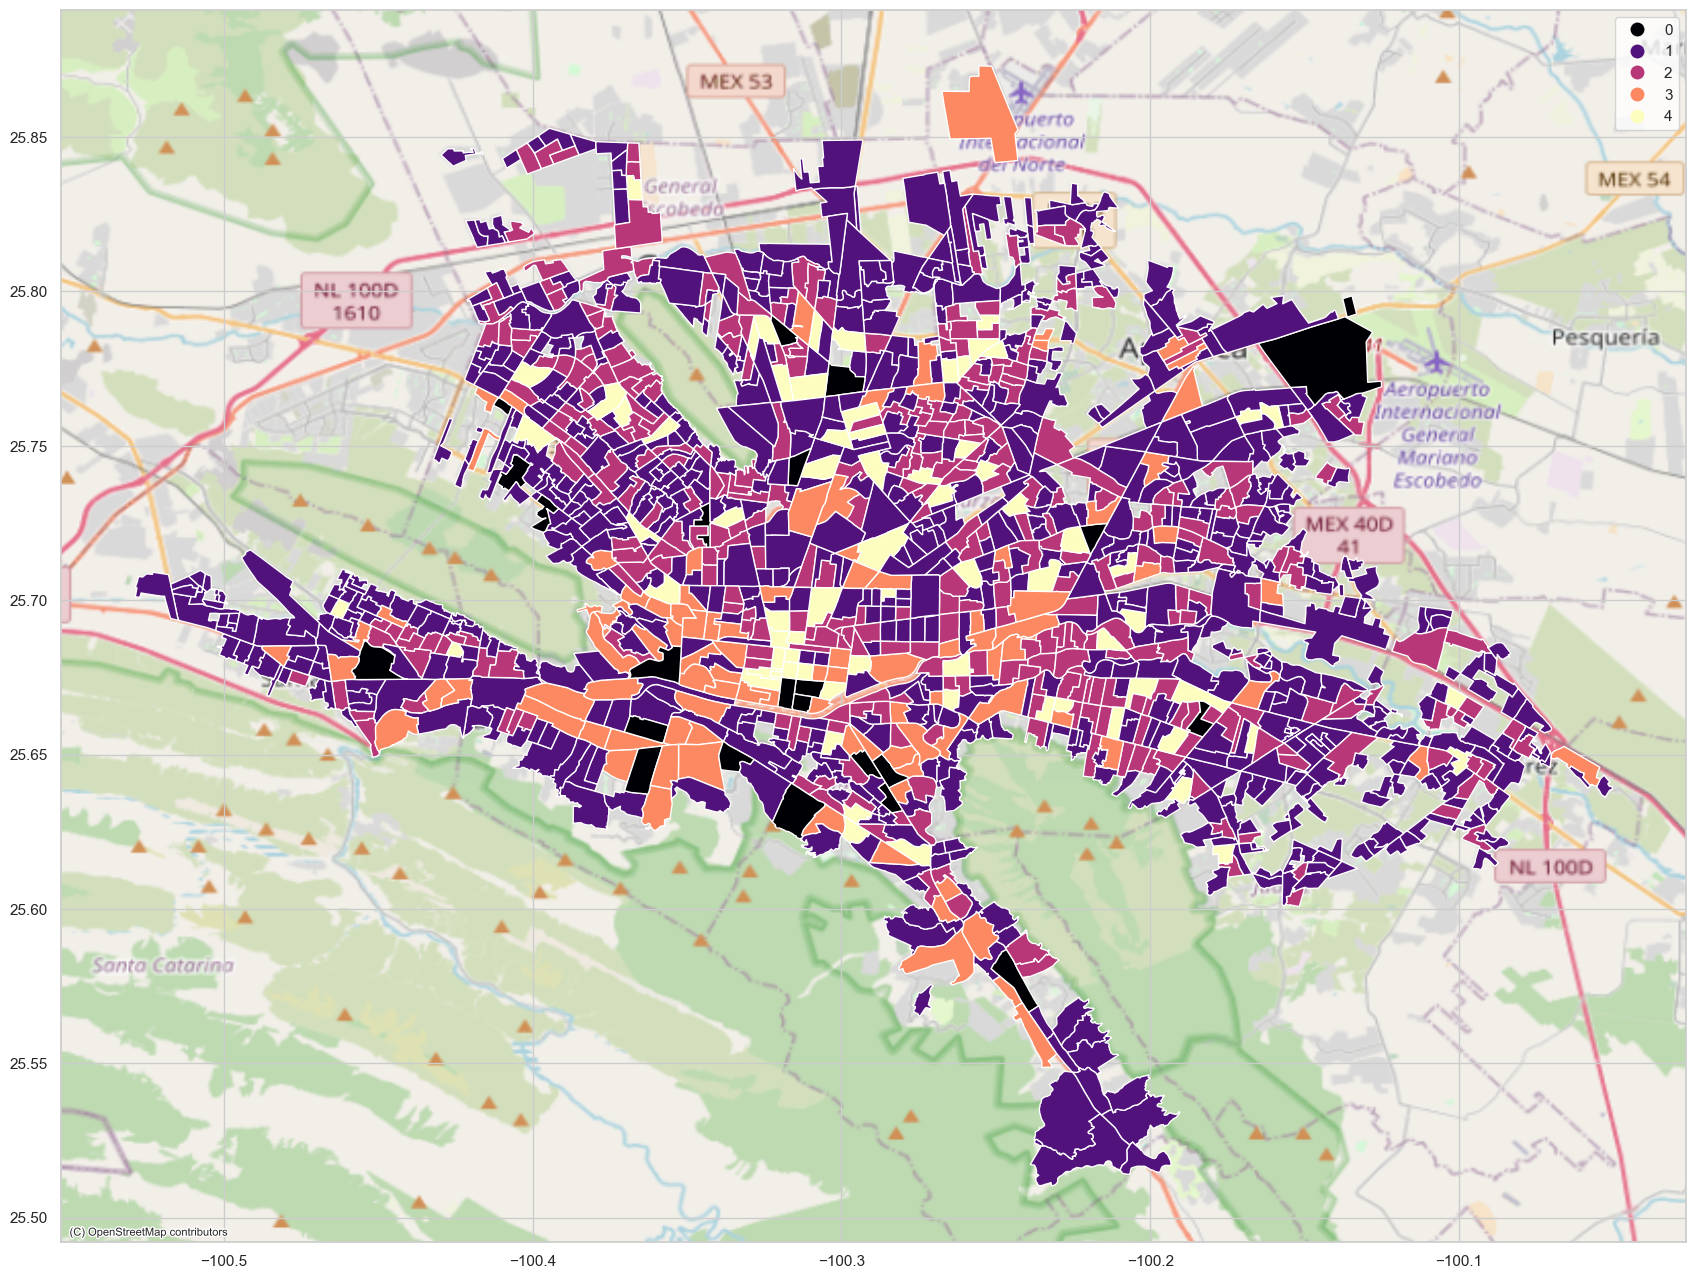

In [783]:
#mostrar clusters en el mapa
ax = gdf.plot("Cluster", cmap="magma", legend=True, figsize=(28, 16), categorical =True)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

## Restaurantes

In [784]:
total_restaurantes = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]

gdf['Tot_Rest'] = gdf[total_restaurantes].sum(axis=1)

In [785]:
gdf['POBREST'] = gdf['POBTOT'] / gdf['Tot_Rest'] 
gdf.head()

CVEMA  MUN  NOM_MUN  AGEB  P12A14NOA  P15YM_AN  P18YM_PB  P6A11_NOAM  \
0  0061882    6  Apodaca  1882         10        67      3404           0   
1  0061435    6  Apodaca  1435          5        16      4582           4   
2  0061647    6  Apodaca  1647          3         6      2822           0   
3  0060969    6  Apodaca  0969          0         0         0           0   
4  006030A    6  Apodaca  030A         10        15      2860           7   

   POBTOT  PSINDER  ...  Rest_Antojitos  Rest_Mariscos  Rest_Rapida  \
0   10712     2186  ...               2              0            3   
1    9224     1185  ...               0              0            1   
2    4650      638  ...               0              0            2   
3       0        0  ...               2              1            3   
4    8268     1230  ...               1              0            1   

   Rest_TacosTortas  Rest_Autoserv  Rest_OtrosLlevar  \
0                 3              1                 3   
1                 1              3                 0   
2                 1              0                 0   
3                 3              6                 0   
4                 0              0                 0   

                                            geometry  Cluster  Tot_Rest  \
0  POLYGON ((-100.15091 25.71505, -100.15099 25.7...        2        12   
1  POLYGON ((-100.16946 25.75323, -100.16861 25.7...        1         5   
2  POLYGON ((-100.23345 25.77729, -100.23349 25.7...        1         3   
3  POLYGON ((-100.18562 25.77552, -100.18542 25.7...        3        23   
4  POLYGON ((-100.16562 25.73954, -100.16554 25.7...        1         2   

       POBREST  
0   892.666667  
1  1844.800000  
2  1550.000000  
3     0.000000  
4  4134.000000  

[5 rows x 28 columns]

In [786]:
gdf[['Tot_Rest','POBREST','POBTOT']].describe()

Tot_Rest       POBREST        POBTOT
count  1287.000000   1287.000000   1287.000000
mean     10.599068   1169.735322   5900.272727
std      10.603233   1395.272537   3241.195867
min       1.000000      0.000000      0.000000
25%       4.000000    364.357143   3731.000000
50%       8.000000    691.200000   5808.000000
75%      14.000000   1373.321429   7866.000000
max     151.000000  12038.000000  22586.000000

## OUTLIERS 

In [787]:
# Calcular la media y la desviación estándar de la columna
mean = gdf['POBREST'].mean()
std_dev = gdf['POBREST'].std()

# Definir un límite (por ejemplo, 3 desviaciones estándar)
cut_off = std_dev * 3
lower, upper = mean - cut_off, mean + cut_off

# Eliminar outliers
gdf_sin_outliers = gdf[(gdf['POBREST'] > 364.357143) & (gdf['POBREST'] < 1373.321429)]

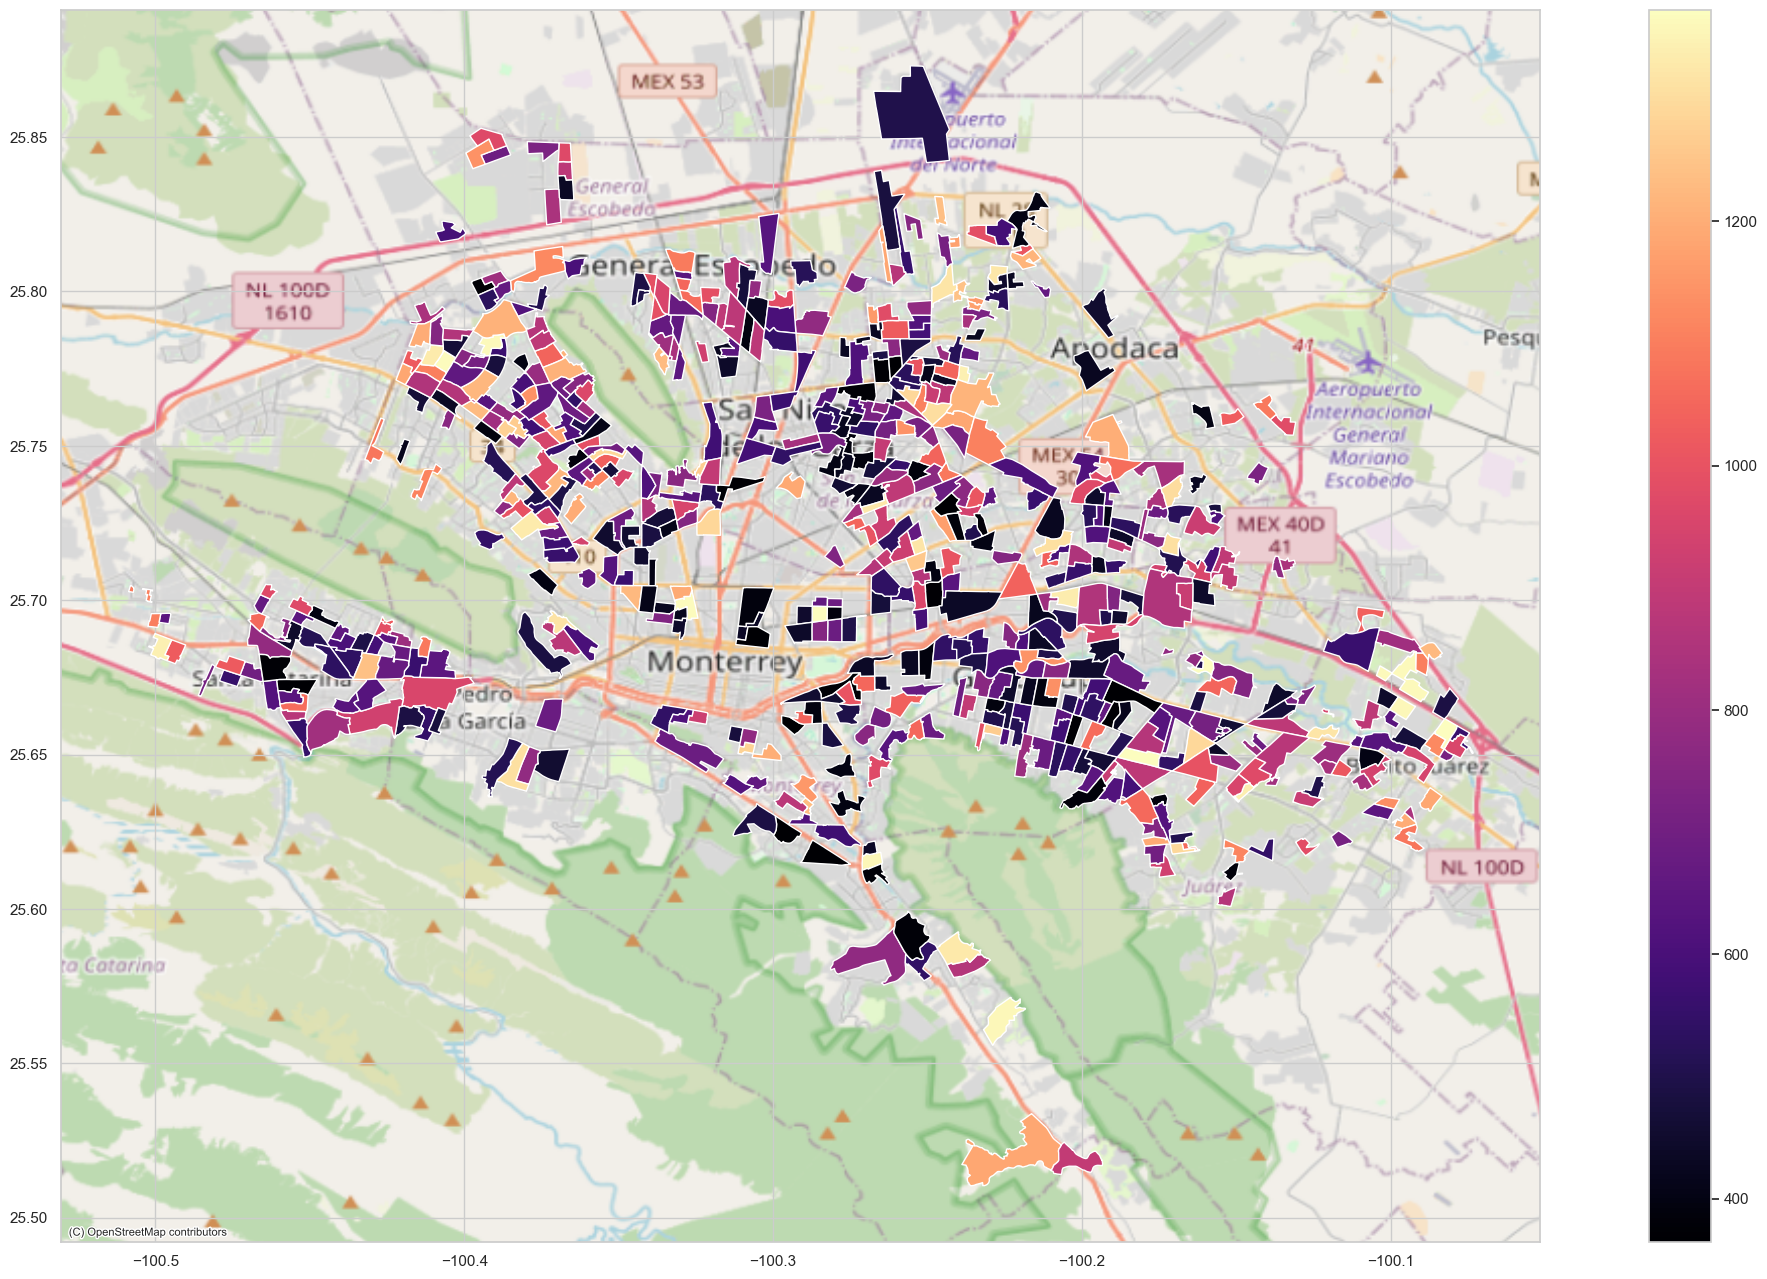

In [788]:
#mostrar Relación Pob Rest eliminando los outliers
ax = gdf_sin_outliers.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [789]:
#conteo de clusters después de filtrar 
gdf_sin_outliers['Cluster'].value_counts()

Cluster
1    344
2    246
3     29
4     24
Name: count, dtype: int64

## Numero de clusters

In [790]:
cluster_numbers = range(1, 11)  # Range

quantization_errors = []

for num_clusters in cluster_numbers:
    np.random.seed()  
    random_seed = np.random.randint(1, 10000)  # Random seed  1 - 10000
    
    # Create SOM
    som = MiniSom(10, 10, data.shape[1], sigma=1.0, learning_rate=0.5, random_seed=random_seed)
    som.random_weights_init(data)
    np.random.shuffle(data)  # Shuffle 
    som.train_random(data, 200) 
    
    # Quantization error
    quantization_error = som.quantization_error(data)
    
    quantization_errors.append(quantization_error)

# Min error
best_num_clusters = cluster_numbers[np.argmin(quantization_errors)]
best_quantization_error = min(quantization_errors)

print(f"Number clusters: {best_num_clusters}")
print(f"Quantization error: {best_quantization_error}")
print(f"Random_state: {random_seed}")



Number clusters: 9
Quantization error: 1.1661392027751734
Random_state: 8061


## SOM

In [791]:
data = datos_normalizados
#data=arr_column


In [792]:
datos_normalizados.shape

(1287, 7)

In [793]:
#Iteraciones para obtención del quantization error
som_shape = (1, best_num_clusters) #num clusters
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=random_seed)

som.train_batch(data, 500, verbose=True)


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.4116849994295566


In [794]:
#Indexing de los clusters
winner_coordinates = np.array([som.winner(x) for x in data]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

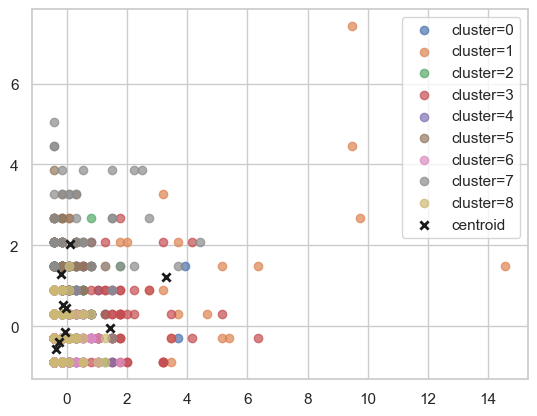

In [795]:
#Plot clusters
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# Plot centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=35, linewidths=2, color='k', label='centroid')
plt.legend();

## Clusters

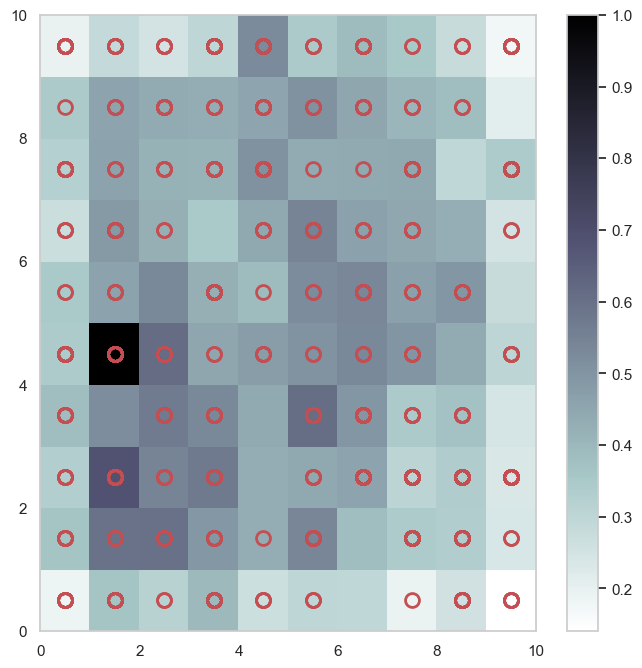

In [796]:
som = MiniSom(10, 10, input_len=7)  
som.train_random(data, 100)  # Inicialización

# Visualize SOM
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # Matrix
plt.colorbar()

#Plot points map
for i, x in enumerate(data):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None', markeredgecolor='r', markersize=10, markeredgewidth=2)

plt.show()

In [797]:
#Obtención valores de clusters
arr = cluster_index

unique_values, counts = np.unique(arr, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0: 89
1: 25
2: 61
3: 64
4: 77
5: 136
6: 592
7: 44
8: 199


In [798]:
#Clusters en dataset para geopandas
gdf['Cluster'] = cluster_index

# distribución de los clusters
print(gdf['Cluster'].value_counts())


Cluster
6    592
8    199
5    136
0     89
4     77
3     64
2     61
7     44
1     25
Name: count, dtype: int64


## Outliers

In [799]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale

In [800]:
#Flatten datos
arr=datos_clustering
arr_column = arr.values.flatten().reshape(-1, 1)

arr_column.shape


(9009, 1)

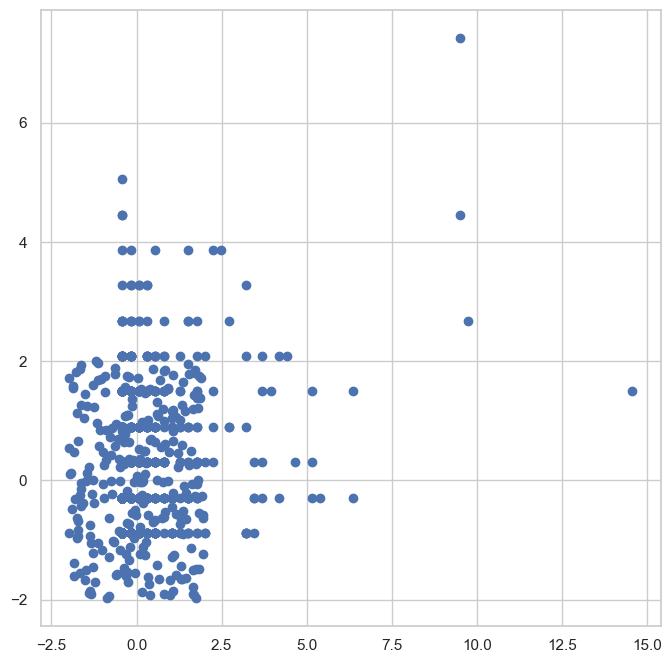

In [801]:
outliers_percentage = 0.5
inliers = 500
outliers = int(inliers * outliers_percentage)


data =datos_clustering

data = scale(data)
data = np.concatenate([data, 
                       (np.random.rand(outliers, 7)-.5)*4.])

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1])
plt.show()

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 2.095234476867205
Error treshold: 1.7859352456689026


/Users/samanthabritoozuna/anaconda3/envs/tecmx/lib/python3.12/site-packages/minisom.py:164: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Text(0, 0.5, 'frequency')

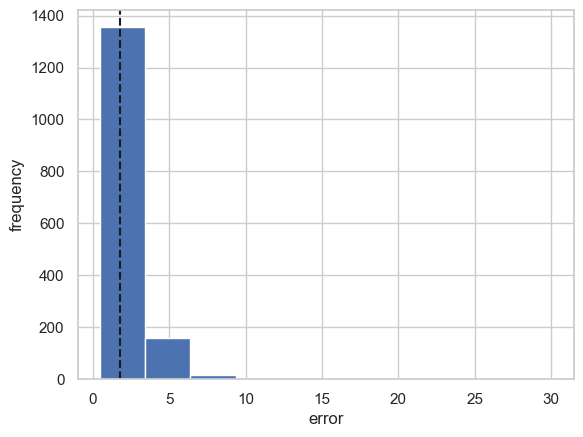

In [802]:
som = MiniSom(2, 1, data.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)


som.train(data, 100, random_order=False, verbose=True)  # random training

quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

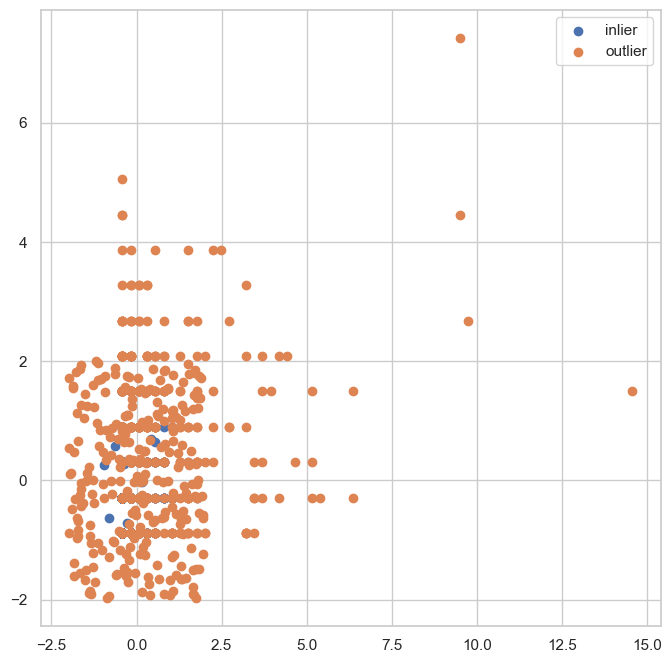

In [803]:
plt.figure(figsize=(8, 8))
plt.scatter(data[~is_outlier, 0], data[~is_outlier, 1],
            label='inlier')
plt.scatter(data[is_outlier, 0], data[is_outlier, 1],
            label='outlier')
plt.legend()
plt.show()

## Tipo restaurantes

In [822]:
import math

In [805]:
#VI features VD labels
features= datos_normalizados
labels = datos_normalizados2[:,7].astype(int)


In [806]:
labels.shape


(1287,)

In [807]:
#Train del mapa set por los features
sigma = 1.5
lr = 0.5
n_features = features.shape[1]
n_samples = features.shape[0]

map_size = 5 * math.sqrt(n_samples)
map_height = map_width = math.ceil(math.sqrt(map_size))


print(f'(map_height, map_width) = ({map_height}, {map_width})')
print(f'Number of features: {n_features}')

(map_height, map_width) = (14, 14)
Number of features: 7


In [808]:
#Quantization error dadas iteraciones
som = MiniSom(x=map_height, y=map_width, input_len=n_features, sigma=sigma, learning_rate=lr, 
              neighborhood_function='gaussian', random_seed=random_seed)
 
som.pca_weights_init(features)
som.train(data=features, num_iteration=1000, verbose=True)  # random training

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.8899443213429127


/Users/samanthabritoozuna/anaconda3/envs/tecmx/lib/python3.12/site-packages/minisom.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


In [809]:
#Distancias
print('-------------\nDistance Map\n------------')
print(f'Shape: {som.distance_map().shape}')
print(f'First Line: {som.distance_map().T[0]}')

-------------
Distance Map
------------
Shape: (14, 14)
First Line: [0.1792399  0.38383319 0.51990991 0.60532959 0.51153587 0.41622694
 0.47028862 0.49765696 0.54078833 0.56546519 0.54475247 0.43366518
 0.30606773 0.15393977]


In [810]:
#Frecuencias 
frequencies = som.activation_response(features)
print(f'Frequencies:\n {np.array(frequencies, np.uint)}')

Frequencies:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  1  7  3  0  0  0  0  0]
 [ 0  0  1  7  7  9  8  8  6  5  0  0  0  0]
 [ 0  0 10  3  8  7  4 14  8  9 10  8  0  0]
 [ 0  3  4 10  7 10 13 14 15 17  7 13  0  0]
 [ 0  4 11 11  7 12  9 16 12 13  3 16  0  0]
 [ 0  2 12 15 15 16 15 10 11 13 11 15  0  0]
 [ 0  3 22 12 12  5 10  8 11 14  3 13  0  0]
 [ 0  2  7 16  6 36 30 30 10 11  5 10  0  0]
 [ 0  0 14 28  0 40 26 18 13  8 10 13  0  0]
 [ 0  0  3  0 23 34 65  6  6  8  6  7  0  0]
 [ 0  0  0 46 13  0 19 12  4  4  6  2  0  0]
 [ 0  0  0  0  9 33  3  7  8  3  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0]]


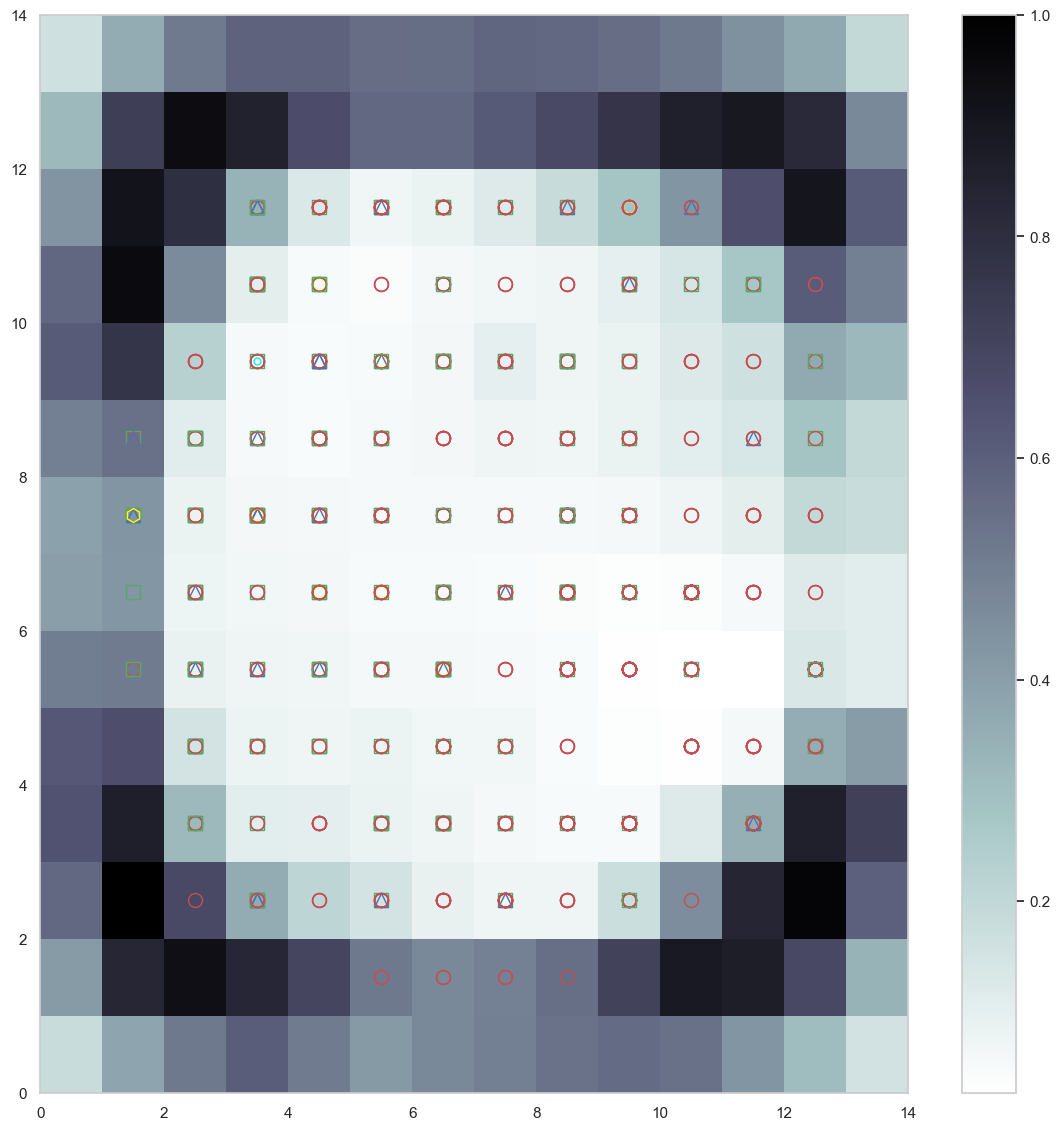

In [811]:
#Plot frecuencias dado el tipo de restaurante
plt.figure(figsize=(map_height, map_width))

# Plot matrix
u_matrix = som.distance_map().T
plt.pcolor(u_matrix, cmap='bone_r')
plt.colorbar()

# Plot markers
markers = ['o', 's', '^','h','*','.',',']   
colors = ['r', 'g', 'b','yellow','pink','cyan','black']
for feature, label in zip(features, labels):
    w = som.winner(feature)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 
        markers[label], markeredgecolor = colors[label], 
        markerfacecolor = 'None', markersize = 10, markeredgewidth = 1)

plt.show()

In [812]:
labels

array([ 1,  1,  0, ..., -1,  0,  0])

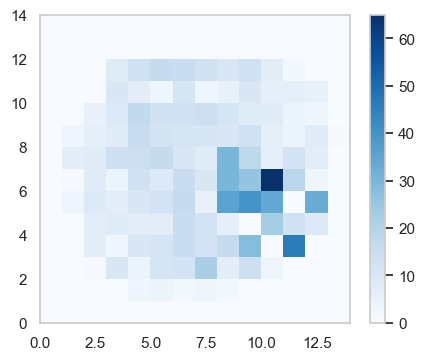

In [813]:
#Plot frecuencias distribution
plt.figure(figsize=(5, 4))
frequencies = som.activation_response(features)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

### Plot

In [814]:
def plot_distance_map(ax, fig):
    """Plot the distance map"""
    p = ax.pcolor(som.distance_map().T, cmap='bone_r') # cmap='Blues'
    fig.colorbar(p, ax=ax)

In [815]:
def plot_clusters_scatter(ax):
 
    winning_neurons = np.array([som.winner(x) for x in features])
    offset = np.random.uniform(low=-0.4, high=0.4, size=(len(features), 2))
    winning_neurons = winning_neurons + offset

    colors = ['r', 'g', 'b','yellow','pink','cyan','black']
    label_colors = [colors[label] for label in labels]

    #Scatter plor
    ax.scatter(winning_neurons[:,0], winning_neurons[:,1], s=10, c=label_colors)

In [816]:
def plot_clusters_markers(ax):
  
    markers = ['o', 's', '^','h','*','.',',']   
    colors = ['r', 'g', 'b','yellow','pink','cyan','black']
    for i, feature in enumerate(features):
        w = som.winner(feature)
        ax.plot(w[0] + 0.5, w[1] + 0.5, 
            markers[labels[i]], markeredgecolor = colors[labels[i]], 
            markerfacecolor = 'None', markersize = 10, markeredgewidth = 1)
        
    # Legend
    ax.legend(handles=[plt.Line2D([], [], color='r', marker='o', linestyle='None', label='R1'),
                    plt.Line2D([], [], color='g', marker='s', linestyle='None', label='R2'),
                    plt.Line2D([], [], color='b', marker='^', linestyle='None', label='R3'),
                    plt.Line2D([], [], color='yellow', marker='h', linestyle='None', label='R4'),
                    plt.Line2D([], [], color='pink', marker='*', linestyle='None', label='R5'),
                    plt.Line2D([], [], color='cyan', marker='.', linestyle='None', label='R6'),
                    plt.Line2D([], [], color='black', marker=',', linestyle='None', label='R7')],
                    bbox_to_anchor=(1.5, 1.03))

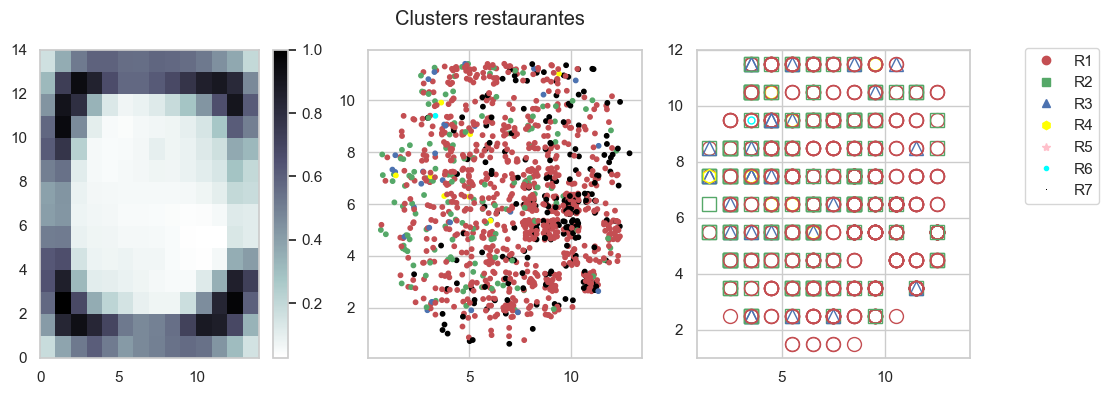

In [817]:
#Plot de los clusters de los restaurantes
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_distance_map(axes[0], fig)
plot_clusters_scatter(axes[1])
plot_clusters_markers(axes[2])

plt.suptitle("Clusters restaurantes")
plt.show()

## Clusters en mapa

In [818]:
# Se seleccionan las columnas numéricas relevantes para el clustering 
columnas_numericas = gdf.select_dtypes(include=np.number).columns.tolist()
columnas_numericas.remove('Cluster')

# Calcula el promedio de cada variable numérica para cada cluster
medias_por_cluster = gdf.groupby('Cluster')[columnas_numericas].mean()

# Columnas de restaurantes
columnas_restaurantes = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]
medias_restaurantes_por_cluster = medias_por_cluster[columnas_restaurantes]

# Muestra las medias de frecuencia de restaurantes por cluster
medias_restaurantes_por_cluster

Rest_Carta  Rest_Antojitos  Rest_Mariscos  Rest_Rapida  \
Cluster                                                           
0          2.022472        2.516854       0.438202     4.325843   
1         19.440000        3.720000       1.960000     3.640000   
2          2.131148        2.016393       2.311475     2.491803   
3          8.078125        1.640625       0.562500     1.718750   
4          1.584416        1.376623       0.194805     1.545455   
5          0.816176        3.610294       0.485294     2.022059   
6          0.518581        0.537162       0.146959     0.717905   
7          4.340909        5.204545       2.181818     6.000000   
8          0.788945        1.145729       0.185930     3.683417   

         Rest_TacosTortas  Rest_Autoserv  Rest_OtrosLlevar  
Cluster                                                     
0                9.887640       0.584270          0.943820  
1                8.720000       7.880000          2.720000  
2                5.885246       0.672131          0.590164  
3                3.609375       2.406250          0.937500  
4                4.077922       0.363636          2.519481  
5                4.602941       0.367647          0.316176  
6                1.621622       0.155405          0.163851  
7               12.159091       0.977273          2.022727  
8                4.246231       0.201005          0.336683

In [819]:
medias_restaurantes_por_cluster.reset_index(inplace=True)
medias_restaurantes_melted = pd.melt(medias_restaurantes_por_cluster, id_vars=['Cluster'], var_name='Tipo de Restaurante', value_name='Frecuencia Promedio')

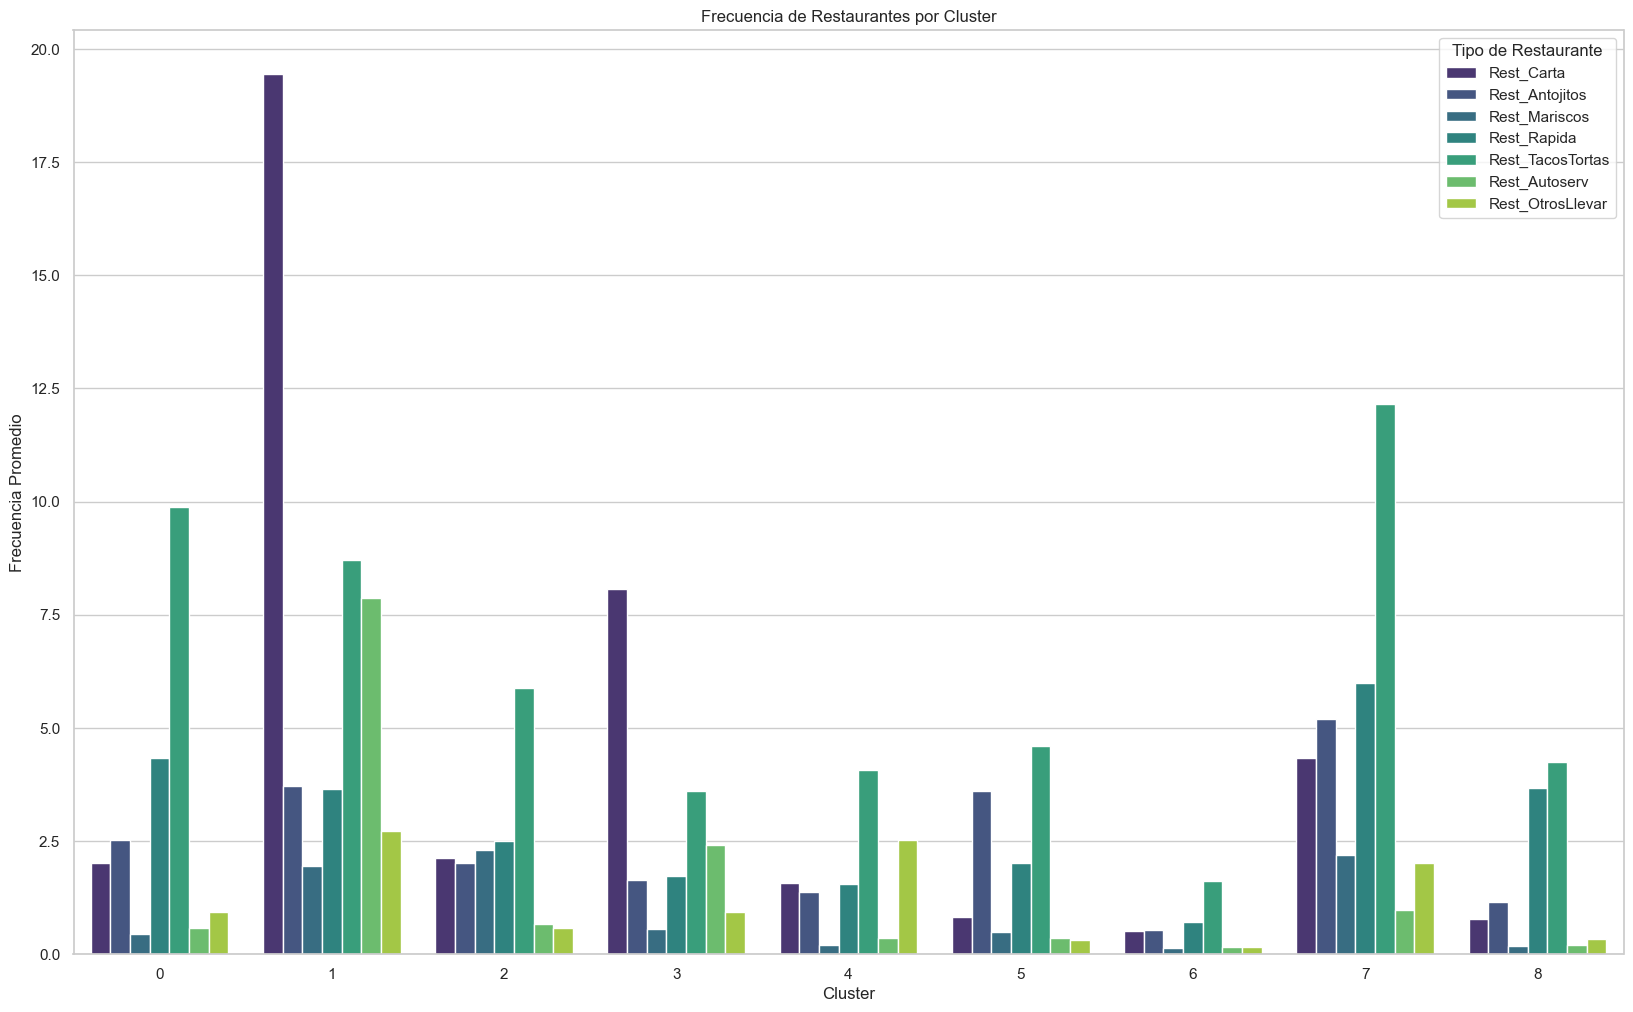

In [820]:
# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Gráfico de barras para las medias de frecuencia de restaurantes por cluster
plt.figure(figsize=(20, 12))
sns.barplot(data=medias_restaurantes_melted, 
            x='Cluster', y='Frecuencia Promedio', hue='Tipo de Restaurante', palette='viridis')
plt.title('Frecuencia de Restaurantes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia Promedio')
plt.legend(title='Tipo de Restaurante')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x
plt.show()

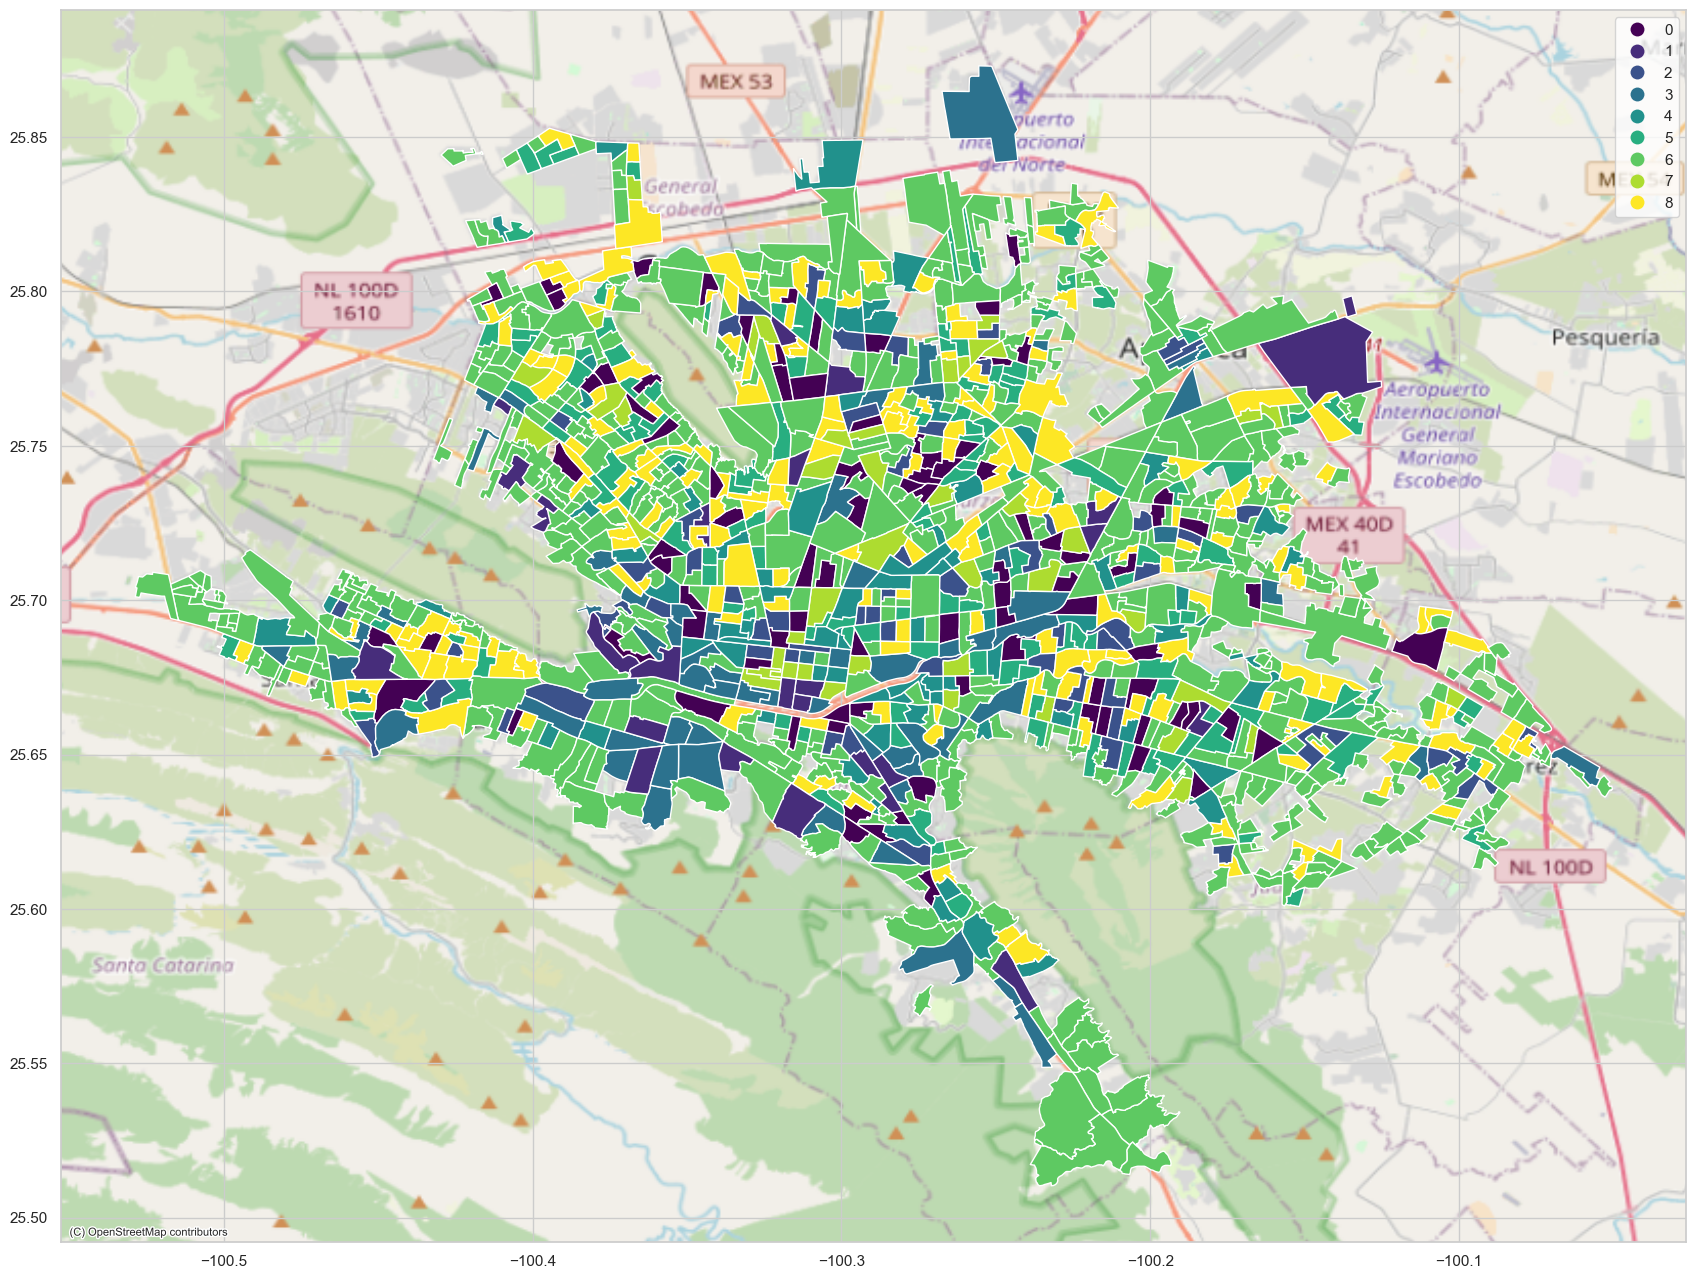

In [821]:
#Clusters representados en el área geográfica dados los Aggebs
ax = gdf.plot("Cluster", cmap="viridis", legend=True, figsize=(28, 16), categorical =True)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)